In [54]:
import pandas as pd
from multiprocessing import Pool
from collections import Counter
import numpy as np
from itertools import chain
import re

In [13]:
indices = pd.read_excel('./results/indices.xlsx')
doculects = pd.read_csv('./files/language_sample.csv', sep = '\t').language.to_list()
it_ct = Counter(dict(indices.value_counts('class').items()))
pos_ct = Counter(['+'.join(tuple(sorted([w.split('/')[1] for w in v.split('+')]))) for v in indices['class']])
#
def get_cats(doc):
    return pd.read_excel('./results/%s.xlsx' % doc)['category'].to_list()
#
with Pool(12) as p:
    cats = p.map(get_cats, doculects)

## read metadata and print table

In [14]:
fam_map = {r.ID:r.Family_ID for i,r in pd.read_csv('./files/glottolog_languoids.csv').iterrows()}
len(fam_map)
dfld = pd.read_csv('./files/languages_and_dialects_geo.csv')
dfld['family'] = [fam_map[g] if g in fam_map else np.nan for g in dfld.glottocode]

metadata = {r.isocodes.upper() : {v : r[v] for v in ['name', 'macroarea', 'latitude', 'longitude','family']}
            for i,r in dfld.iterrows() if not pd.isna(r.isocodes)}

In [16]:
names = {r.ID:r.Name for i,r in pd.read_csv('./files/glottolog_languoids.csv').iterrows()}
ltab = [[d] + [(metadata[d[:3]][n] if n != 'family' else
                (names[metadata[d[:3]][n]] if not pd.isna(metadata[d[:3]][n]) else metadata[d[:3]][n]))
               for n in ['name','family', 'macroarea']] for d in sorted(doculects)]
print(pd.DataFrame(ltab, columns = ['ISO 639-3', 'name', 'family', 'macroarea']).to_latex(index=False))

\begin{tabular}{llll}
\toprule
ISO 639-3 & name & family & macroarea \\
\midrule
AAUWBT & Abau & Sepik & Papunesia \\
ACMAS3 & Gilit Mesopotamian Arabic & Afro-Asiatic & Eurasia \\
ACUTBL & Achuar-Shiwiar & Chicham & South America \\
AGGPNG & Angor & Senagi & Papunesia \\
AGMWBT & Angaataha & Angan & Papunesia \\
ALYXXX & Alyawarr & Pama-Nyungan & Australia \\
AMFSIM & Hamer-Banna & South Omotic & Africa \\
AMKWBT & Ambai & Austronesian & Papunesia \\
AMMWBT & Ama (Papua New Guinea) & Left May & Papunesia \\
AMNPNG & Amanab & Border & Papunesia \\
AMPWBT & Alamblak & Sepik & Papunesia \\
AMRTBL & Amarakaeri & Harakmbut & South America \\
AMUMVR & Guerrero Amuzgo & Otomanguean & North America \\
AOJFIL & Mufian & Nuclear Torricelli & Papunesia \\
ARLTBL & Arabela & Zaparoan & South America \\
AVAANT & Avar & Nakh-Daghestanian & Eurasia \\
AVTWBT & Au & Nuclear Torricelli & Papunesia \\
AZZTBL & Highland Puebla Nahuatl & Uto-Aztecan & North America \\
BBOBSM & Northern Bobo Madaré & Mand

## prepare dataframe

In [21]:
dfx = pd.concat([indices]*len(doculects), axis = 0)
dfx['category'] = list(chain(*cats))
dfx['language'] = list(chain(*[[doc]*len(indices) for doc in doculects]))
dfx = dfx[dfx.category.isin({1,2,3,4})].reindex()
dfx['synlexify'] = dfx.category == 4

In [22]:
dfx['pair_frequencies'] = [np.log(it_ct[v]) for v in dfx['class']]
dfx['pos_type'] = ['+'.join(tuple(sorted([w.split('/')[1] for w in v.split('+')]))) for v in dfx['class']]
dfx['macroarea'] = [metadata[l[:3]]['macroarea'] for l in dfx['language']]

In [23]:
dfx.to_csv('./files/results_overview.csv')

## $\S$6.1 across the lexicon

In [24]:
type_level = dfx.groupby(['language', 'class','pos_type'], as_index=False).agg({'synlexify' : ['mean']})
type_level['dom.synlexify'] = type_level.synlexify >= 0.5

In [25]:
per_class = type_level.groupby(['pos_type', 'class'], as_index=False).agg({('dom.synlexify',''):['sum'], ('synlexify','mean'):['mean']})

### PoS pairs

In [28]:
# top and bottom pairs per pos_type
top_types = [k for k,v in Counter(type_level.pos_type).most_common(10)]
for pos_type in top_types:
    per_class_pos = per_class[per_class[('pos_type','')] == pos_type]
    per_class_pos_positive = per_class_pos[per_class_pos[('dom.synlexify', '','sum')] > 0]
    print('\\multirow{2}{*}{%s (N=%d; %d\\%%)}' % (pos_type, len(per_class_pos), 100*len(per_class_pos_positive)/len(per_class_pos)), 
          ' & bottom = ', ' '.join('%s (%d)' % (re.sub('/[A-Z]+', '', r[('class','','')]).replace('_','-'), r[('dom.synlexify','','sum')])
                          for i,r in per_class_pos_positive.sort_values(('dom.synlexify', '','sum')).iloc[0:10].iterrows()), '\\\\'
          ' & top = ',  ' '.join(['%s (%d)' % (re.sub('/[A-Z]+', '', r[('class','','')]).replace('_','-'), r[('dom.synlexify','','sum')])
                   for i,r in per_class_pos.sort_values(('dom.synlexify', '','sum')).iloc[-10:].iterrows()][::-1]), '\\\\')

\multirow{2}{*}{ADP+NOUN (N=461; 18\%)}  & bottom =  about+thing (1) accord+with (1) voice+with (1) before+man (1) book+of (1) of+rich (1) of+star (1) of+sign (1) country+of (1) demon+of (1) \\ & top =  mountain+on (116) before+foot (80) in+peace (72) disciple+of (46) of+son (41) demon+in (27) of+woe (26) gold+of (18) in+world (17) city+in (14) \\
\multirow{2}{*}{ADP+VERB (N=460; 19\%)}  & bottom =  before+fall (1) before+go (1) before+set (1) beg+to (1) owe+to (1) over+throw (1) belong+to (1) believe+in (1) bring+up (1) bind+with (1) \\ & top =  rise+up (107) get+up (104) down+fall (95) cry+out (85) before+defile (84) down+sit (81) stand+up (67) out+release (60) at+marvel (49) cut+off (42) \\
\multirow{2}{*}{NOUN+VERB (N=408; 37\%)}  & bottom =  understand+word (1) bear+tree (1) sit+throne (1) language+speak (1) say+woman (1) fear+speak (1) man+name (1) man+right (1) enter+place (1) eye+open (1) \\ & top =  bread+eat (173) law+write (164) apostle+send (163) eat+food (161) steal+thief 

/tmp/ipykernel_3342581/3635302760.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_class_pos = per_class[per_class[('pos_type','')] == pos_type]


In [29]:
top_types = [k for k,v in Counter(type_level.pos_type).most_common(10)]
for pos_type in top_types:
    per_class_pos = per_class[per_class[('pos_type','')] == pos_type]
    per_class_pos_positive = per_class_pos[per_class_pos[('dom.synlexify', '','sum')] > 0]
    print('%s & %d & %s' % ('+'.join(k[0] for k in pos_type.split('+')), len(per_class_pos), 
                            ('%.2f' % (len(per_class_pos_positive)/len(per_class_pos))).lstrip('0')), 
          ' & ' + ' '.join(['%s (%d)' % (re.sub('/[A-Z]+', '', r[('class','','')]).replace('_','-'), r[('dom.synlexify','','sum')])
                           for i,r in per_class_pos.sort_values(('dom.synlexify', '','sum')).iloc[-3:].iterrows()][::-1]), '\\\\')

A+N & 461 & .18  & mountain+on (116) before+foot (80) in+peace (72) \\
A+V & 460 & .19  & rise+up (107) get+up (104) down+fall (95) \\
N+V & 408 & .38  & bread+eat (173) law+write (164) apostle+send (163) \\
V+V & 245 & .20  & deceive+lie (162) suffer+torment (146) persecute+suffer (120) \\
N+N & 198 & .81  & boat+ship (186) boat+sea (186) horse+soldier (184) \\
A+N & 87 & .68  & blind+eye (179) blood+dead (178) famine+hungry (172) \\
A+V & 86 & .90  & er+teach (142) ant+serve (105) er+pray (105) \\
P+V & 84 & .10  & Peter+answer (2) Jesus+answer (1) Christ+die (1) \\
A+N & 82 & .87  & et+trump (178) enemy+st (166) a-ed+shame (144) \\
P+V & 79 & .20  & to+want (25) lose+not (8) circumcise+not (4) \\


/tmp/ipykernel_3342581/2420358350.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_class_pos = per_class[per_class[('pos_type','')] == pos_type]


### fields

In [30]:
def motion_verb(r):
    fields = set(r.split('+'))
    if fields & {'get/VERB', 'rise/VERB', 'sit/VERB', 'go/VERB','come/VERB','enter/VERB', 'put/VERB', 'throw/VERB',
                 'stand/VERB', 'depart/VERB', 'ascent/VERB', 'fall/VERB', 'cast/VERB', 'pour/VERB'} == set(): return False
    if fields & {'in/ADP', 'up/ADP', 'down/ADP', 'out/ADP', 'back/ADV', 'from/ADP', 'on/ADP', 'to/ADP', 'off/ADP'} == set(): return False
    return True

def speech_verb(r):
    fields = set(r.split('+'))
    if fields & {'say/VERB', 'tell/VERB', 'speak/VERB', 'talk/VERB'} == set(): return False
    return True

In [31]:
# generate motion verb table    
dfq = per_class[[motion_verb(r) for r in per_class[('class','')]]]
dfq[('pair freq.','','')] = [it_ct[v] for v in dfq[('class','','')]]
dfqq = dfq.sort_values(('dom.synlexify','','sum'), ascending=False)
print(dfqq[[('class','',''),('dom.synlexify','','sum'),('pair freq.','','')]].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
class & dom.synlexify & pair freq. \\
 &  &  \\
 & sum &  \\
\midrule
rise/VERB+up/ADP & 107 & 29 \\
get/VERB+up/ADP & 104 & 19 \\
down/ADP+fall/VERB & 95 & 83 \\
down/ADP+sit/VERB & 81 & 42 \\
stand/VERB+up/ADP & 67 & 21 \\
cast/VERB+out/ADP & 33 & 39 \\
out/ADP+pour/VERB & 29 & 21 \\
depart/VERB+from/ADP & 29 & 11 \\
come/VERB+down/ADP & 9 & 69 \\
go/VERB+up/ADP & 8 & 61 \\
down/ADP+throw/VERB & 4 & 15 \\
down/ADP+go/VERB & 3 & 29 \\
enter/VERB+in/ADP & 3 & 191 \\
out/ADP+throw/VERB & 3 & 22 \\
get/VERB+in/ADP & 3 & 10 \\
on/ADP+stand/VERB & 3 & 17 \\
go/VERB+out/ADP & 2 & 117 \\
from/ADP+rise/VERB & 2 & 31 \\
on/ADP+sit/VERB & 2 & 66 \\
come/VERB+out/ADP & 1 & 132 \\
come/VERB+from/ADP & 0 & 107 \\
fall/VERB+on/ADP & 0 & 37 \\
fall/VERB+in/ADP & 0 & 29 \\
fall/VERB+from/ADP & 0 & 12 \\
enter/VERB+to/ADP & 0 & 175 \\
come/VERB+to/ADP & 0 & 1173 \\
come/VERB+on/ADP & 0 & 88 \\
come/VERB+up/ADP & 0 & 31 \\
depart/VERB+to/ADP & 0 & 11 \\
come/VERB+in/ADP & 

/tmp/ipykernel_3342581/271787119.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  dfq = per_class[[motion_verb(r) for r in per_class[('class','')]]]
/tmp/ipykernel_3342581/271787119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfq[('pair freq.','','')] = [it_ct[v] for v in dfq[('class','','')]]


In [32]:
# generate speech verb table
dfq = per_class[[speech_verb(r) for r in per_class[('class','')]]]
dfq[('pair freq.','','')] = [it_ct[v] for v in dfq[('class','','')]]
dfqq = dfq.sort_values(('dom.synlexify','','sum'), ascending=False)
print(len(dfqq), sum(dfqq[('dom.synlexify','','sum')] < 3))
print(dfqq[[('class','',''),('dom.synlexify','','sum'),('pair freq.','','')]].to_latex(index=False))

201 189
\begin{tabular}{lrr}
\toprule
class & dom.synlexify & pair freq. \\
 &  &  \\
 & sum &  \\
\midrule
promise/NOUN+say/VERB & 63 & 57 \\
false/ADJ+say/VERB & 54 & 23 \\
answer/VERB+say/VERB & 42 & 279 \\
say/VERB+thunder/NOUN & 27 & 11 \\
ask/VERB+say/VERB & 27 & 185 \\
confess/VERB+say/VERB & 13 & 16 \\
say/VERB+speak/VERB & 12 & 329 \\
sin/NOUN+speak/VERB & 12 & 32 \\
ar/AFX+say/VERB & 9 & 10 \\
say/VERB+write/VERB & 6 & 266 \\
lie/VERB+say/VERB & 4 & 30 \\
command/VERB+say/VERB & 3 & 135 \\
speak/VERB+still/ADV & 2 & 10 \\
say/VERB+word/NOUN & 2 & 452 \\
prophet/NOUN+speak/VERB & 1 & 13 \\
language/NOUN+speak/VERB & 1 & 20 \\
fear/NOUN+speak/VERB & 1 & 10 \\
among/ADP+say/VERB & 1 & 10 \\
Isaiah/PROPN+say/VERB & 1 & 11 \\
say/VERB+to/ADP & 1 & 1675 \\
say/VERB+woman/NOUN & 1 & 16 \\
Peter/PROPN+say/VERB & 1 & 48 \\
cry/VERB+say/VERB & 1 & 75 \\
say/VERB+still/ADV & 1 & 10 \\
beg/VERB+say/VERB & 1 & 14 \\
Paul/PROPN+say/VERB & 1 & 23 \\
get/VERB+say/VERB & 0 & 21 \\
concern/VER

/tmp/ipykernel_3342581/1975909202.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  dfq = per_class[[speech_verb(r) for r in per_class[('class','')]]]
/tmp/ipykernel_3342581/1975909202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfq[('pair freq.','','')] = [it_ct[v] for v in dfq[('class','','')]]


In [34]:
type_level_wide = type_level.pivot(index='class', columns='language', values=('synlexify','mean'))
print('types dominant in no language', sum((type_level_wide > 0.5).sum(1) == 0))
print('types dominant in >50% of languages', sum((type_level_wide > 0.5).sum(1) > len(doculects)/2))
print('total types', len(type_level_wide))

types dominant in no language 1715
types dominant in >50% of languages 152
total types 2563


## $\S$6.2 areal effects

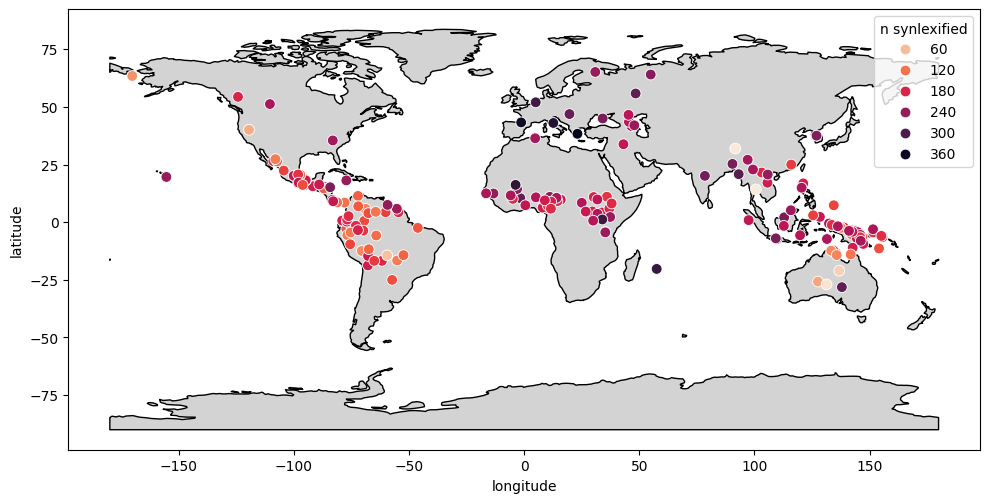

In [51]:
outdir = './files/worldmap.png'
from matplotlib import pyplot as plt 
import geodatasets, geopandas
gdf = geopandas.read_file(geodatasets.get_path('naturalearth land'))


bldr = []
for k,v in zip((type_level_wide > 0.5).sum(0).index, (type_level_wide > 0.5).sum(0)):
    bldr.append([k,v,metadata[k[:3]]['longitude'],metadata[k[:3]]['latitude'],metadata[k[:3]]['macroarea']])
df_world = pd.DataFrame(bldr, columns = ['doculect', 'n synlexified', 'longitude', 'latitude', 'macroarea'])
fig, ax = plt.subplots(1,1,figsize=(10,8))
gdf.plot(color='lightgray', edgecolor='black', ax=ax)
sns.scatterplot(data=df_world, x='longitude', y='latitude', hue='n synlexified', palette='rocket_r', s=60, ax=ax)
plt.tight_layout()
plt.savefig(outdir)

In [52]:
df_world.groupby('macroarea').agg({'n synlexified' : 'mean'})

,n synlexified
macroarea,
Africa,214.615385
Australia,121.555556
Eurasia,227.518519
North America,172.848485
Papunesia,189.537037
South America,149.527778


## prepare data table for $\S$6.3

In [53]:
logreg_tab = type_level.copy()
logreg_tab.columns = ['doculect', 'pair', 'pos.type', 'synlexify.prop', 'synlexified']
logreg_tab['synlexified'] = [int(t) for t in logreg_tab['synlexified']]
logreg_tab['log.pair.freq'] = [np.log(it_ct[v]) for v in logreg_tab['pair']]
logreg_tab['macroarea'] = [metadata[d[:3]]['macroarea'] for d in logreg_tab['doculect']]
top_pos_pairs = {k for k,v in Counter(logreg_tab['pos.type']).most_common(5)}
logreg_tab['pos.type'] = [p if p in top_pos_pairs else 'other' for p in logreg_tab['pos.type']]
logreg_tab.to_csv('./files/statmodel_synlexification.csv')